# *Minecraft NLP Project*
### Presented by: Rae Downen, Cristina Lucin, Michael Mesa and John "Chris" Rosenberger

---

## Project Overview

This project focuses on building a prediction model for accurately predicting the coding language of a project using examination of GitHub repo README files. Our goal is to develop a predictive model utilizing Python and Python libraries, and select the most effective model for production. Initially, we are utilizing BeautifulSoup to acquire our data, selecting 1000 repositories tagged with 'Minecraft' from GitHub, taking in all Readme text and repo language information from each repo. After gathering the data, we explore the data through questions and visualizations before developing a model that can tell us: "What language is this repository most likely to be written in?"

## Goals
### Create deliverables:
* READ ME
* Final Report
* Functional acquire.py, explore.py, and model.py files
* Acquire data from GitHub utilizing Beautiful Soup to scrape targeted Repositories ('Repos')
* Prepare and split the data
* Explore the data
* Establish a baseline
* Fit and train a classification model to predict the programming language of the Repo
* Evaluate the model by comparing its performance on train utilizing accuracy as a measure
* Evaluate the selected model on test data
* Develop and document findings, takeaways, recommendations and next steps

In [1]:
#General DS Imports
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
import matplotlib as plt
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
from PIL import Image

#Modeling, NLP and Exploration
from requests import get
from bs4 import BeautifulSoup
import json
from typing import Dict, List, Optional, Union, cast
import requests
import re
import time
import unicodedata
import nltk
from sklearn.model_selection import train_test_split

#My imports
import os
from env import github_token, github_username
from importlib import reload
import acquire as a
import explore as e
import prepare as p
import modeling as m

/opt/homebrew/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Aquire
* 1,000 Repo URLs tagged "Minecraft" were aquired from GitHub utilizing a .py script "acquire_minecraft_urls.py"
* These Repos were identified and scraped through the search feature in GitHub
* Repo Readme Text and Repo Language was scraped utilizing BeautifulSoup
* Readme Text and Repo Language was collected into a dictionary using a function called "process_repo.py" and "scrape_github_data"
* This dictionary was turned into a dataframe and CSV file
* The CSV file contained 1,000 rows and 3 features before cleaning
* Each row represents a unique Repo located on Github
* Each column represents a feature of the Repo, such as URL, Readme text, or Programming Language

# Prepare
#### Prepare Actions:
* Renamed columns to improve readability
* Removed white space from values in object columns
* Checked for null values in the data, dropped all rows where nulls existed
* Utilized Regex and string methods and fucntions to clean Repo readme text

In [2]:
#Import our data from a .csv file, take a peek at the data
df = pd.read_csv(r'clean_scraped_data.csv', index_col=[0])
df.head()

,repo,language,readme_contents,clean,lemmatized
1,fogleman/Minecraft,Python,# Minecraft\n\nSimple Minecraft-inspired demo ...,minecraft simple minecraftinspired demo writte...,minecraft simple minecraftinspired demo writte...
2,itzg/docker-minecraft-server,Shell,[![Docker Pulls](https://img.shields.io/docker...,docker pullshttpsimgshieldsiodockerpullsitzgmi...,docker pullshttpsimgshieldsiodockerpullsitzgmi...
3,overviewer/Minecraft-Overviewer,Python,====================================\nMinecraf...,minecraft overviewer build status andrew brown...,minecraft overviewer build status andrew brown...
4,TheGreyGhost/MinecraftByExample,Java,MinecraftByExample [1.16.4]\n=================...,minecraftbyexample 1164 purpose minecraftbyexa...,minecraftbyexample 1164 purpose minecraftbyexa...
5,minecraft-dev/MinecraftDev,Kotlin,"<p align=""center""><a href=""https://minecraftde...",p aligncentera hrefhttpsminecraftdevorgimg src...,p aligncentera hrefhttpsminecraftdevorgimg src...


In [3]:
# top 20 languages from Readme files
df.language.value_counts().head(20)

Java          402
JavaScript     86
Python         76
C#             43
C++            36
Shell          35
PHP            33
Kotlin         23
TypeScript     22
Go             19
C              16
Rust           15
Lua             6
HTML            6
ZenScript       5
Ruby            5
CSS             4
GLSL            4
Dockerfile      4
Scala           4
Name: language, dtype: int64

### We chose to focus on the top 3 programming languages found in the scraped Repos, classifying all other languages as "Other":

In [4]:
#Recast other languages as "Other"
df = p.map_other_languages(df)
df.head()

,repo,language,readme_contents,clean,lemmatized
1,fogleman/Minecraft,Python,# Minecraft\n\nSimple Minecraft-inspired demo ...,minecraft simple minecraftinspired demo writte...,minecraft simple minecraftinspired demo writte...
2,itzg/docker-minecraft-server,Other,[![Docker Pulls](https://img.shields.io/docker...,docker pullshttpsimgshieldsiodockerpullsitzgmi...,docker pullshttpsimgshieldsiodockerpullsitzgmi...
3,overviewer/Minecraft-Overviewer,Python,====================================\nMinecraf...,minecraft overviewer build status andrew brown...,minecraft overviewer build status andrew brown...
4,TheGreyGhost/MinecraftByExample,Java,MinecraftByExample [1.16.4]\n=================...,minecraftbyexample 1164 purpose minecraftbyexa...,minecraftbyexample 1164 purpose minecraftbyexa...
5,minecraft-dev/MinecraftDev,Other,"<p align=""center""><a href=""https://minecraftde...",p aligncentera hrefhttpsminecraftdevorgimg src...,p aligncentera hrefhttpsminecraftdevorgimg src...


In [5]:
df.language.value_counts()

Java          402
Other         320
JavaScript     86
Python         76
Name: language, dtype: int64

### Cleaning: We elected to remove words such as 'minecraft', 'server', 'run', etc by utilizing stopwords through a prepare function:

In [6]:
#Remove stopwords from dataframe
df = p.prep_readme_data(df, 'readme_contents')
df.head()

Removed 151 stopwords
---
Removed 4745 stopwords
---
Removed 207 stopwords
---
Removed 505 stopwords
---
Removed 155 stopwords
---
Removed 76 stopwords
---
Removed 9 stopwords
---
Removed 1439 stopwords
---
Removed 208 stopwords
---
Removed 35 stopwords
---
Removed 336 stopwords
---
Removed 222 stopwords
---
Removed 243 stopwords
---
Removed 257 stopwords
---
Removed 177 stopwords
---
Removed 222 stopwords
---
Removed 102 stopwords
---
Removed 73 stopwords
---
Removed 204 stopwords
---
Removed 231 stopwords
---
Removed 10 stopwords
---
Removed 136 stopwords
---
Removed 13 stopwords
---
Removed 211 stopwords
---
Removed 676 stopwords
---
Removed 2218 stopwords
---
Removed 132 stopwords
---
Removed 585 stopwords
---
Removed 681 stopwords
---
Removed 206 stopwords
---
Removed 704 stopwords
---
Removed 130 stopwords
---
Removed 70 stopwords
---
Removed 117 stopwords
---
Removed 256 stopwords
---
Removed 1172 stopwords
---
Removed 128 stopwords
---
Removed 215 stopwords
---
Removed 74 stopw

,repo,language,readme_contents,clean,lemmatized
1,fogleman/Minecraft,Python,# Minecraft\n\nSimple Minecraft-inspired demo ...,simple minecraftinspired demo written python p...,simple minecraftinspired demo written python p...
2,itzg/docker-minecraft-server,Other,[![Docker Pulls](https://img.shields.io/docker...,docker pullshttpsimgshieldsiodockerpullsitzgmi...,docker pullshttpsimgshieldsiodockerpullsitzgmi...
3,overviewer/Minecraft-Overviewer,Python,====================================\nMinecraf...,overviewer build status andrew brown contribut...,overviewer build status andrew brown contribut...
4,TheGreyGhost/MinecraftByExample,Java,MinecraftByExample [1.16.4]\n=================...,minecraftbyexample 1164 purpose minecraftbyexa...,minecraftbyexample 1164 purpose minecraftbyexa...
5,minecraft-dev/MinecraftDev,Other,"<p align=""center""><a href=""https://minecraftde...",p aligncentera hrefhttpsminecraftdevorgimg src...,p aligncentera hrefhttpsminecraftdevorgimg src...


### Train-Test Split

* For exploration, we chose to do a train test split taking 20% for test, %30 of that for validate, and the remainder for train

In [7]:
train, validate, test = e.split_minecraft_data(df)
train.head()

,repo,language,readme_contents,clean,lemmatized
47,danba340/minecraft-freecodecamp,JavaScript,# Welcome to React three fiber Minecraft\n\nTh...,welcome react three fiber project trying mimic...,welcome react three fiber project trying mimic...
822,BentoBoxWorld/AOneBlock,Java,"# AOneBlock\nA OneBlock Minecraft plugin, writ...",aoneblock oneblock plugin written tastybento c...,aoneblock oneblock plugin written tastybento c...
279,PGMDev/PGM,Java,PGM ![deploy](https://github.com/Electroid/PGM...,pgm deployhttpsgithubcomelectroidpgmworkflowsd...,pgm deployhttpsgithubcomelectroidpgmworkflowsd...
901,SandboxPowered/Sandbox,Java,"<p align=""center"">\n <img src=""https://raw....",p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...
266,mraof/Minestuck,Java,Minestuck\n=========\n\n* Discord Server: http...,minestuck discord httpsdiscordappcominvitetekw...,minestuck discord httpsdiscordappcominvitetekw...


## Question 1: What are the top programming languages found in #Minecraft GitHub Repos?

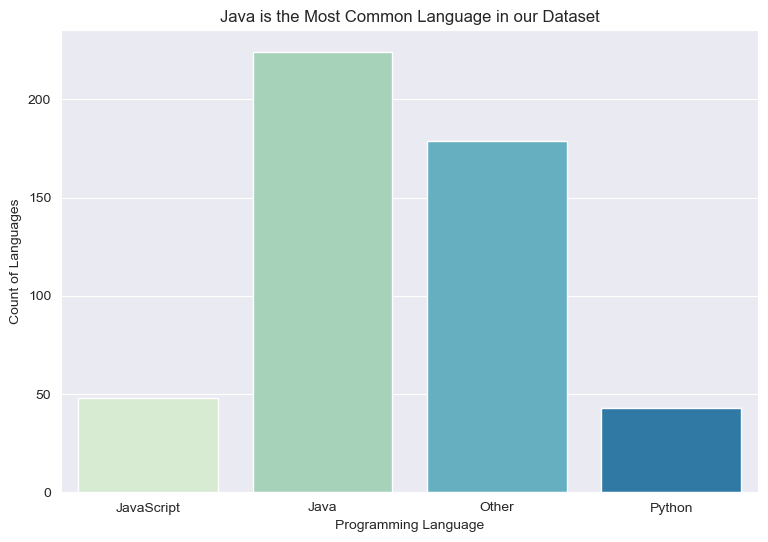

In [8]:
e.get_language_freq(train)

### Java was the most common language found in the Repos that we scraped from, followed by JavaScript and Python. All other languages are included in this visualization. This information made sense, considering that Minecraft was developed using Java.

----------

## Question 2: What is the average wordcount of a Repo Readme file, based on their programming language?

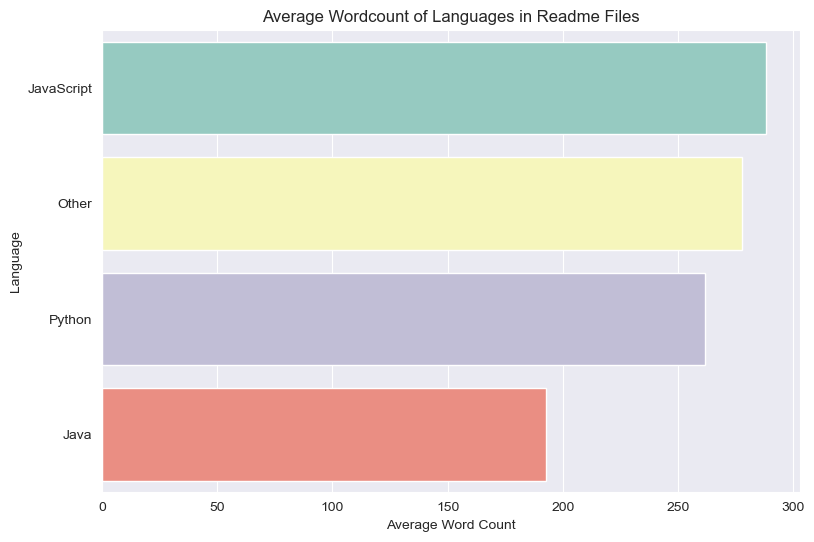

In [9]:
e.get_wordcount_bar(train)

## Question 3: What are the top 10 most frequent words found in Python Repos?

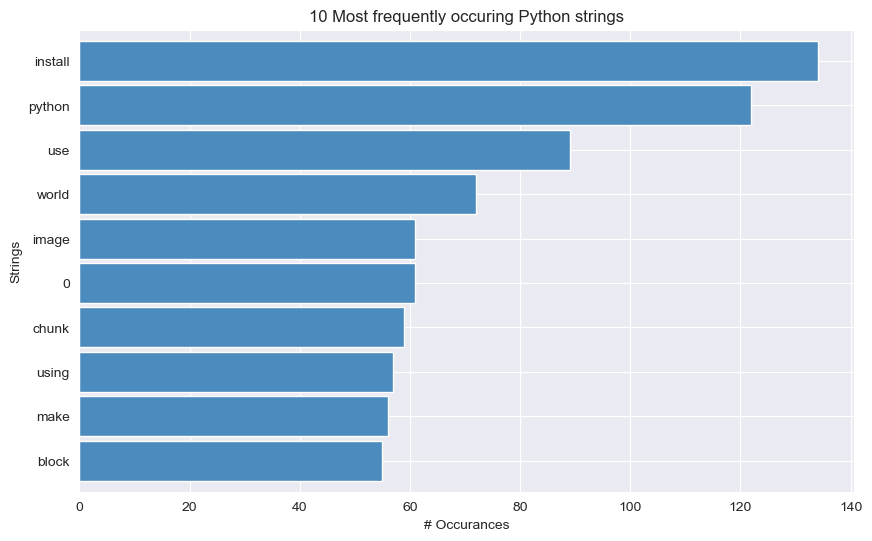

In [10]:
e.get_top10_python(train)

## Question 4: What are the top 10 most frequent words found in Java Repos?

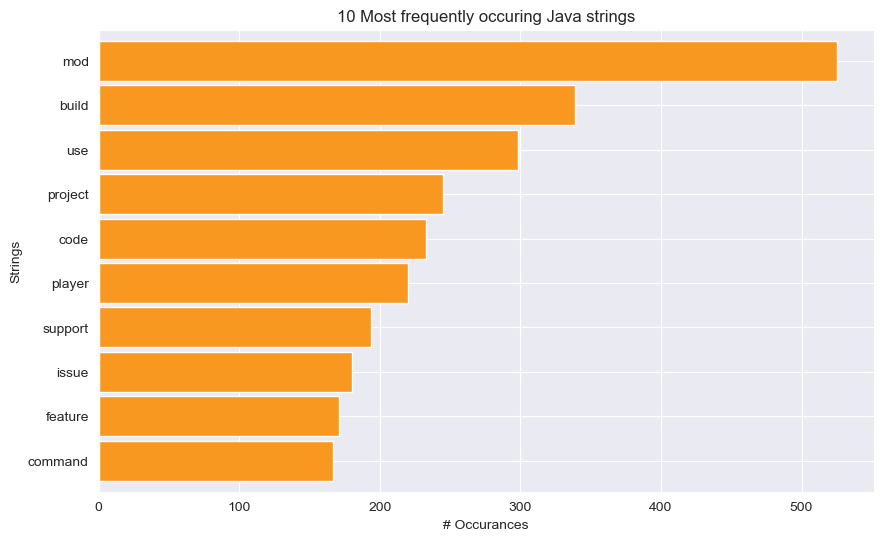

In [11]:
e.get_top10_java(train)

## Question 4: What are the top 10 most frequent words found in JavaScript Repos?

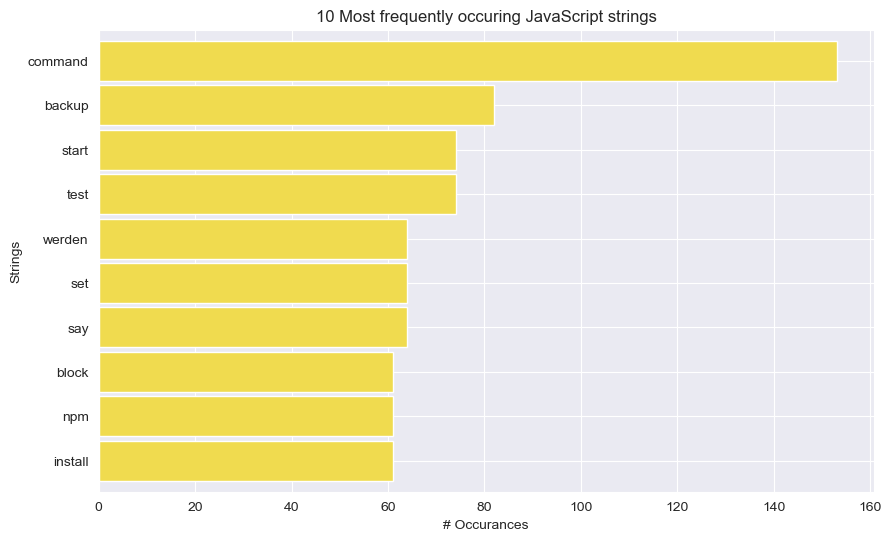

In [12]:
e.get_top10_js(train)

## Exploration Summary
* Java was the most frequent language found in the Repositories examined
* Javascript Repos had the highest average wordcount, Java Repos had the lowest
* "Install" was the most common word for Python Repos
* "Mod" and "Build" were the most frequently found Java strings
* "Command" was the most frequent word found in JavaScript Repos


----

# Modeling

* We elected to utilize accuracy as the evaluation metric
* We developed three different models using differnt model types: (Naive Bayes, SKLearn Gradient Booster, XG Boost)
* The model that performs the best was evaluated on test data
* **We utilized the mode of 'language' as the baseline (Java, 45.3)**

We explored several methods of NLP modeling. We elected to utilize as much useful text as possible. This is a multilabel classification project which makes the confusion matrix more complicated than more common classification problems. Due to that, we decided that the large string of text would be more useful for finding differences between the languages used in the Readme files.

We trained several models on our training set without hyperparameter tuning to produce models that were 'Good Enough'. These models overfit on training data. A problem with the differentiation within Readme files is that they all utilize normal, human language to describe a programming process. Because the Readme does not necessarily use specialized programming language, this made classification much more difficult.

---

## Initial model training

---

### Naive Bayes, SKLearn Gradient Booster and Extreme Gradient Boosting (XGBoost)

In [13]:
m.get_model_tests()

Naive Bayes train
              precision    recall  f1-score   support

        Java       0.95      1.00      0.97       276
  JavaScript       0.97      0.59      0.73        61
       Other       0.89      0.95      0.92       230
      Python       0.95      0.82      0.88        51

    accuracy                           0.92       618
   macro avg       0.94      0.84      0.88       618
weighted avg       0.93      0.92      0.92       618

SKLearn Gradient Booster train
              precision    recall  f1-score   support

        Java       1.00      0.99      1.00       276
  JavaScript       1.00      1.00      1.00        61
       Other       0.99      1.00      1.00       230
      Python       1.00      1.00      1.00        51

    accuracy                           1.00       618
   macro avg       1.00      1.00      1.00       618
weighted avg       1.00      1.00      1.00       618

[15:47:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4

/opt/homebrew/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Extreme Gradient Boosting training
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       276
           1       1.00      0.97      0.98        61
           2       1.00      1.00      1.00       230
           3       1.00      1.00      1.00        51

    accuracy                           1.00       618
   macro avg       1.00      0.99      0.99       618
weighted avg       1.00      1.00      1.00       618



---

*All models selected overfit the training data. We elected to utilize **SK Learn Gradient Boosting** because SK Learn is an open source algorithm with a lot of support.*

---

### Testing Selected model on unseen (test) data

In [14]:
#SK Learn Gradient Boosting Test
m.gb_test()

SKLearn Gradient Booster test
              precision    recall  f1-score   support

        Java       0.84      0.82      0.83       126
  JavaScript       0.79      0.60      0.68        25
       Other       0.65      0.73      0.69        90
      Python       0.78      0.72      0.75        25

    accuracy                           0.76       266
   macro avg       0.77      0.72      0.74       266
weighted avg       0.77      0.76      0.76       266



## Modeling Summary
* All models were overfit on the training data
* SKLearn Gradient Boost was chosen for test data
* **This model performed with a 76 percent accuracy, a 30 percent improvement from the baseline**

---

# Takeaways/ Conclusions

- GitHub Repos with different programming languages have significantly different features (Word count and unique words)
- Because ReadMe files are written in normal language, the accuracy of any model is limited
- Improved cleaning methods may increase model performance
- Count Vectorization (CV) in combination with ensemble classification is an effective modeling strategy for NLP/Text Classification problems

# Recommendations

- Acquire longer Readme text files to feed into algorithm
- Narrow down parameters for classifications (more languages are more difficult to classify)
* Additional hyperparameter tuning may result in better model performance

# Next Steps

* Utilize statistical methods to identify additional stopwords
* Develop and test different model types for performance
* Find alternative methods for pulling repo data from GitHub